Now analysis of parsed data from part 1.

Useful ref http://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/

http://stackoverflow.com/questions/21828398/what-is-the-difference-between-pandas-agg-and-apply-function

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import wilcoxon  # must import explicitly
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext watermark
%watermark -a 'Robin_Cole' -u -d -v -p numpy,pandas,matplotlib

Robin_Cole 
last updated: 2016-10-13 

CPython 3.5.2
IPython 5.1.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.3


In [3]:
pwd

'C:\\Users\\RCole02.ROYALSURREY\\Desktop\\GitHub\\Useful-python-for-medical-physics\\Experiments in ipython notebooks\\Project'

## Helper functions

In [4]:
def query_data(Col, structure, metric):   # helper function to get data, Col = AAA, AXB or diff
    temp = d[Col][(d['structure'] == structure) & (d['metric'] == metric)]
    return temp

In [5]:
def diff_percent(a,ref):
    return 100*((a-ref)/ref)

print(diff_percent(25.0,100.0))

-75.0


In [6]:
def my_wilcox(data):                    # helper function to return p-value, pass difference data as series from dataframe
    z_stat, p_val = wilcoxon(data)   # if only 1 value passed
    #z_stat, p_val = wilcoxon(data.as_matrix())   # if only 1 value passed
    return p_val

In [7]:
my_wilcox([1,2,3,4,6,7,2,352,3])

C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


0.0075792819433897285

In [8]:
def bland_altman_plot(data1, data2, structure, metric, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    z_stat, p_val = wilcoxon(data1, data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='red', linestyle='-')
    plt.axhline(md + 1.96*sd, color='blue', linestyle='--')
    plt.axhline(md - 1.96*sd, color='blue', linestyle='--')
    plt.xlabel('Dose (Gy)')
    plt.ylabel('Difference (Gy)')
    plt.title( str(np.round(md, decimals = 3)) + ' Gy differnece with p = ' + str(np.round(p_val, decimals = 3))  + ' for ' + structure + ' and metric ' + metric)
    plt.savefig('BA.png')

## Import and clean data 

In [9]:
d = pd.read_csv('AAA_Dm_data_30_9.csv')

Drop entries with no values, and calculate percent difference

In [10]:
d = d[d.AAA != 0]    # drop zero rows

In [11]:
#d = d[d.structure != 'L Brachial plex']   # drop these
#d = d[d.structure != 'Both Lungs']
#d = d[d.metric != 'V20GY']
#d = d[d.metric != 'V30GY']
#d = d[d.metric != 'V40GY']
#d = d[d.metric != 'V50GY']
#d = d[d.metric != 'V55GY']
#d = d[d.metric != 'DRX']

In [12]:
# d['diff'] = diff_percent(d.Dm, d.AAA)  # create % difference col

In [13]:
d['diff'] = d.Dm - d.AAA  # create absolute difference col, not %

In [14]:
d.head()

,Case,structure,metric,AAA,Dm,diff
0,Case1,BODY,D2%,25.853042,25.685894,-0.167149
1,Case1,BODY,D5%,14.523130,14.388797,-0.134333
2,Case1,BODY,D50%,0.430243,0.399853,-0.030390
3,Case1,BODY,D95%,0.047550,0.065952,0.018402
4,Case1,BODY,D99%,0.009510,0.022860,0.013350


In [24]:
#d.describe()

In [16]:
d.loc[d['diff'].idxmax()] # Some large differences for Brachial plex, INVESTIGATE

Case                  Case31
structure    R Brachial plex
metric                   DHI
AAA                  44.7183
Dm                   781.014
diff                 736.296
Name: 4978, dtype: object

In [23]:
#d[d['diff']>20]   # see the extreme cases

In [18]:
#d = d[d['diff']<100.0] # drop extreme cases where difference is greater than 100%

In [19]:
d.metric.unique()

array(['D2%', 'D5%', 'D50%', 'D95%', 'D99%', 'D1CC', 'D0.1CC', 'DMAX',
       'DSD', 'DRX', 'DHI', 'V5GY', 'V12.5GY', 'V20GY', 'V30GY', 'V40GY',
       'V50GY', 'V55GY'], dtype=object)

In [20]:
d.structure.unique()

array(['BODY', 'GTV', 'Heart', 'Foramen', 'Foramen+3mm', 'Oesophagus',
       'Trachea', 'Bronchial tree', 'L Brachial plex', 'R Brachial plex',
       'Airway avoidance', 'PTV CHEST', 'Lt_Lung', 'PTV ring 2-3cm',
       'Rt_Lung', 'Both Lungs-ITV', 'Skin', 'Ribs', 'Skin-PTV+2cm', 'ITV',
       'Ribs-PTV', 'Inner Ring', 'Body', 'Both Lungs', 'Great vessels',
       'Liver'], dtype=object)

In [22]:
print(d.Case.unique().size)
d.Case.unique()

15


array(['Case1', 'Case5', 'Case11', 'Case12', 'Case13', 'Case14', 'Case16',
       'Case17', 'Case21', 'Case22', 'Case24', 'Case25', 'Case30',
       'Case31', 'Case32'], dtype=object)

# Check against constraints

In [25]:
constraints = pd.read_csv('SABR_lung_constraints.csv')
constraints = constraints.drop('3_Fraction_54Gy', 1)   # drop 54 Gy

In [26]:
# constraints[(constraints['Structure'] == 'PTV CHEST') & (constraints['Metric'] == 'D95%')]
constraints = constraints[constraints['metric'].isin(d.metric.unique())]   # get only constraints where we have exported metrics
constraints

,structure,metric,Sign,5_Fraction_55Gy,Unit,Of_Prescription_dose?
0,PTV CHEST,D95%,>,100,%,1
1,PTV CHEST,D99%,>,90,%,1
2,PTV CHEST,D0.1CC,between,118-134,%,1
3,Foramen,DMAX,<,25,Gy,0
4,Oesophagus,D0.1CC,<,27,Gy,0
5,R Brachial plex,D0.1CC,<,27,Gy,0
6,L Brachial plex,D0.1CC,<,27,Gy,0
7,Heart,D0.1CC,<,27,Gy,0
8,Trachea,D0.1CC,<,32,Gy,0
9,Bronchial tree,D0.1CC,<,32,Gy,0


In [27]:
PTV_D95_fail = d[(d['structure'] == 'PTV CHEST') & (d['metric'] == 'D95%') & (d['AAA'] > 55.0) & (d['Dm'] < 55.0)]
#print(wilcoxon(test_df['diff'])) 
PTV_D95_fail

,Case,structure,metric,AAA,Dm,diff
489,Case5,PTV CHEST,D95%,55.648904,54.883221,-0.765683
4287,Case30,PTV CHEST,D95%,56.172306,51.618767,-4.553539


In [28]:
PTV_D99_fail = d[(d['structure'] == 'PTV CHEST') & (d['metric'] == 'D99%') & (d['AAA'] > 0.9*55.0) & (d['Dm'] < 0.9*55.0)]
PTV_D99_fail  

,Case,structure,metric,AAA,Dm,diff


In [29]:
PTV_D01CC_fail = d[(d['structure'] == 'PTV CHEST') & (d['metric'] == 'D0.1CC') & (((d['AAA'] > 1.18*55) & (d['Dm'] < 1.18*55)) | ((d['AAA'] < 1.34*55) & (d['Dm'] > 1.34*55)))]
print(1.18*55)
print(1.34*55)
PTV_D01CC_fail

64.89999999999999
73.7


,Case,structure,metric,AAA,Dm,diff
4740,Case31,PTV CHEST,D0.1CC,72.846993,74.024337,1.177344


In [30]:
Foramen_D01CC_fail = d[(d['structure'] == 'Foramen') & (d['metric'] == 'DMAX') & (d['AAA'] < 25.0) & (d['Dm'] > 25.0)]
Foramen_D01CC_fail  

,Case,structure,metric,AAA,Dm,diff


In [31]:
Oesophagus_D01CC_fail = d[(d['structure'] == 'Oesophagus') & (d['metric'] == 'D0.1CC') & (d['AAA'] < 27.0) & (d['Dm'] > 27.0)]
Oesophagus_D01CC_fail  

,Case,structure,metric,AAA,Dm,diff


In [32]:
LBrachial_D01CC_fail = d[(d['structure'] == 'L Brachial plex') & (d['metric'] == 'D0.1CC') & (d['AAA'] < 27.0) & (d['Dm'] > 27.0)]
LBrachial_D01CC_fail  

,Case,structure,metric,AAA,Dm,diff
1122,Case12,L Brachial plex,D0.1CC,0.108812,74.346465,74.237653
3912,Case25,L Brachial plex,D0.1CC,0.054618,63.428739,63.374121
4650,Case31,L Brachial plex,D0.1CC,0.109680,77.576481,77.466802


In [33]:
RBrachial_D01CC_fail = d[(d['structure'] == 'R Brachial plex') & (d['metric'] == 'D0.1CC') & (d['AAA'] < 27.0) & (d['Dm'] > 27.0)]
RBrachial_D01CC_fail  

,Case,structure,metric,AAA,Dm,diff
222,Case1,R Brachial plex,D0.1CC,0.324991,65.801627,65.476636
2814,Case17,R Brachial plex,D0.1CC,0.435957,48.809596,48.373640


In [34]:
Heart_D01CC_fail = d[(d['structure'] == 'Heart') & (d['metric'] == 'D0.1CC')& (d['Dm'] > 27.0) & (d['AAA'] < 27.0)]
Heart_D01CC_fail 

,Case,structure,metric,AAA,Dm,diff


In [35]:
Trachea_D01CC_fail = d[(d['structure'] == 'Trachea') & (d['metric'] == 'D0.1CC') & (d['AAA'] < 32.0) & (d['Dm'] > 32.0)]
Trachea_D01CC_fail  

,Case,structure,metric,AAA,Dm,diff
3966,Case25,Trachea,D0.1CC,15.948424,69.349889,53.401465


In [36]:
Bronchial_D01CC_fail = d[(d['structure'] == 'Bronchial tree') & (d['metric'] == 'D0.1CC') & (d['AAA'] < 32.0) & (d['Dm'] > 32.0)]
Bronchial_D01CC_fail 

,Case,structure,metric,AAA,Dm,diff


In [37]:
Ribs_D01CC_fail = d[(d['structure'] == 'Ribs') & (d['metric'] == 'D0.1CC') & (d['AAA'] < 35.0) & (d['Dm'] > 35.0)]
Ribs_D01CC_fail 

,Case,structure,metric,AAA,Dm,diff


In [38]:
Ribs_V30_fail = d[(d['structure'] == 'Ribs') & (d['metric'] == 'V30GY') & (d['AAA'] < 30.0) & (d['Dm'] > 30.0)]
Ribs_V30_fail 

,Case,structure,metric,AAA,Dm,diff


In [39]:
Lungs_V20_fail = d[(d['structure'] == 'Both Lungs-ITV') & (d['metric'] == 'V20GY') & (d['AAA'] < 10.0) & (d['Dm'] > 10.0)]
Lungs_V20_fail 

,Case,structure,metric,AAA,Dm,diff


In [40]:
Lungs_V125_fail = d[(d['structure'] == 'Both Lungs-ITV') & (d['metric'] == 'V12.5GY') & (d['AAA'] < 15.0) & (d['Dm'] > 15.0)]
Lungs_V125_fail 

,Case,structure,metric,AAA,Dm,diff


In [41]:
Lungs_V5_fail = d[(d['structure'] == 'Both Lungs-ITV') & (d['metric'] == 'V5GY') & (d['AAA'] < 26.0) & (d['Dm'] > 26.0)]
Lungs_V5_fail 

,Case,structure,metric,AAA,Dm,diff


In [42]:
Liver_D50_fail = d[(d['structure'] == 'Liver') & (d['metric'] == 'D50%') ]
Liver_D50_fail   

,Case,structure,metric,AAA,Dm,diff
3458,Case22,Liver,D50%,1.250632,1.294880,0.044248
4196,Case25,Liver,D50%,6.847959,6.713133,-0.134825


Need to export Lungs-ITV D1500CC, D1000CC, Liver 700CC, V21, V15, DMEAN

Investigate these failures.

In [43]:
failures = PTV_D95_fail
failures = failures.append(PTV_D01CC_fail)
failures = failures.append(Trachea_D01CC_fail)
failures = failures.append(Liver_D50_fail)
failures = failures.append(LBrachial_D01CC_fail)
failures = failures.append(RBrachial_D01CC_fail)

print(failures.Case.unique().size)
failures

8


,Case,structure,metric,AAA,Dm,diff
489,Case5,PTV CHEST,D95%,55.648904,54.883221,-0.765683
4287,Case30,PTV CHEST,D95%,56.172306,51.618767,-4.553539
4740,Case31,PTV CHEST,D0.1CC,72.846993,74.024337,1.177344
3966,Case25,Trachea,D0.1CC,15.948424,69.349889,53.401465
3458,Case22,Liver,D50%,1.250632,1.294880,0.044248
4196,Case25,Liver,D50%,6.847959,6.713133,-0.134825
1122,Case12,L Brachial plex,D0.1CC,0.108812,74.346465,74.237653
3912,Case25,L Brachial plex,D0.1CC,0.054618,63.428739,63.374121
4650,Case31,L Brachial plex,D0.1CC,0.109680,77.576481,77.466802
222,Case1,R Brachial plex,D0.1CC,0.324991,65.801627,65.476636


##  PTV D95 data

In [44]:
d_PTV =  d[d['structure']  == 'PTV CHEST'].groupby(['metric'])
d_PTV = d_PTV.diff.mean()  # get mean diff values
# d_PTV.sort_values(ascending=False) #d_PTV.groups.keys()

In [131]:
# d_PTV.sort_values(ascending=False).plot(kind='bar', figsize=(8,6))

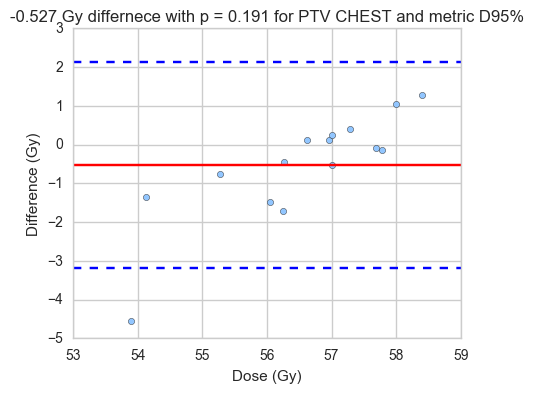

In [46]:
fig = plt.figure(figsize=(5, 4))
structure = 'PTV CHEST'
metric = 'D95%'
bland_altman_plot(query_data('Dm', structure, metric), query_data('AAA',structure, metric), structure, metric)
plt.show()

Histograms of data PTV data

C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


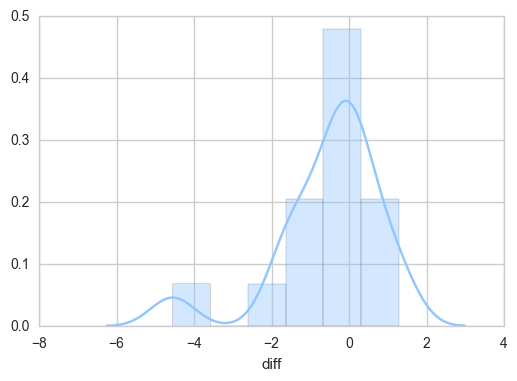

In [47]:
#ax2 = sns.distplot(query_data('diff', 'PTV CHEST', 'D50%'))   # quick test

fig = plt.figure(figsize=(6, 4))
data=query_data('diff', 'PTV CHEST', 'D95%')

# plt.subplot(1, 2, 1)
ax2 = sns.distplot(data)

#plt.subplot(1, 2, 2)
#ax = sns.violinplot(data)  

In [48]:
data=query_data('diff', 'PTV CHEST', 'D50%')
# ax = sns.violinplot(data)  

# Extract stats grouped by structure for D50% metric

In [50]:
stats = {  'Mean' : 'mean', 'Variance':'var', 'SEM':'sem', 'Counts':'count', 'Max':'max'} 

aggregations = {'diff': stats}  # , 'AAA': stats, 'Dm': stats

res_table = d[d['metric']  == 'D50%'].groupby(['structure']).agg(aggregations)   # returns a heirachial dataframe
res_table

diff                                           
                 Counts      Mean        Max       SEM    Variance
structure                                                         
Airway avoidance     14 -0.018405   0.053335  0.009802    0.001345
BODY                 14 -0.003599   0.011675  0.004211    0.000248
Body                  1  0.001679   0.001679       NaN         NaN
Both Lungs            5 -0.008474   0.014224  0.013606    0.000926
Both Lungs-ITV       15 -0.018235   0.032892  0.010556    0.001672
Bronchial tree       15  0.007682   0.128285  0.016811    0.004239
Foramen              15 -0.071230   0.025543  0.020161    0.006097
Foramen+3mm          18 -0.071668   0.024562  0.022756    0.009321
GTV                   1 -0.900259  -0.900259       NaN         NaN
Great vessels         1 -0.049074  -0.049074       NaN         NaN
Heart                15 -0.006242   0.050727  0.009650    0.001397
ITV                  14  0.568196   1.828439  0.195352    0.534273
Inner Ring            6  0.283500   0.567988  0.090871    0.049546
L Brachial plex      14  4.801599  39.023162  3.137878  137.847887
Liver                 2 -0.045289   0.044248  0.089537    0.016034
Lt_Lung              15 -0.036095   0.012416  0.008498    0.001083
Oesophagus           15 -0.025135   0.032761  0.023482    0.008271
PTV CHEST            15  0.235042   1.697743  0.265863    1.060251
PTV ring 2-3cm       15  0.201877   0.763267  0.086762    0.112914
R Brachial plex      15  1.258501  18.718139  1.247171   23.331538
Ribs                 15 -0.058496   0.181102  0.027261    0.011147
Ribs-PTV             13 -0.040976   0.015631  0.015306    0.003046
Rt_Lung              15 -0.029733   0.006038  0.010315    0.001596
Skin                 14 -0.025002  -0.002897  0.004431    0.000275
Skin-PTV+2cm          6 -0.001662   0.019201  0.006728    0.000272
Trachea              15 -0.000304   0.067776  0.007223    0.000783

In [52]:
# res_table['diff']['Max']  # get only diff > Max

In [53]:
# res_table.loc[constraints['structure'].unique()]

In [54]:
# d[(d['structure'] == 'PTV CHEST') & (d['metric'] == 'D50%')] 

# Mean difference grouped by structure and metric

In [55]:
res_table2 = d.groupby(['structure', 'metric'],as_index=False).mean()  # just get mean values 

In [56]:
mean_diff_table = res_table2.pivot(index='structure', columns='metric', values='diff')  # pivot table for diff values
#diff_table.reset_index(level=0, inplace=True)    # must convert the index back into a column
mean_diff_table.index
# diff_table.loc['BODY']

Index(['Airway avoidance', 'BODY', 'Body', 'Both Lungs', 'Both Lungs-ITV',
       'Bronchial tree', 'Foramen', 'Foramen+3mm', 'GTV', 'Great vessels',
       'Heart', 'ITV', 'Inner Ring', 'L Brachial plex', 'Liver', 'Lt_Lung',
       'Oesophagus', 'PTV CHEST', 'PTV ring 2-3cm', 'R Brachial plex', 'Ribs',
       'Ribs-PTV', 'Rt_Lung', 'Skin', 'Skin-PTV+2cm', 'Trachea'],
      dtype='object', name='structure')

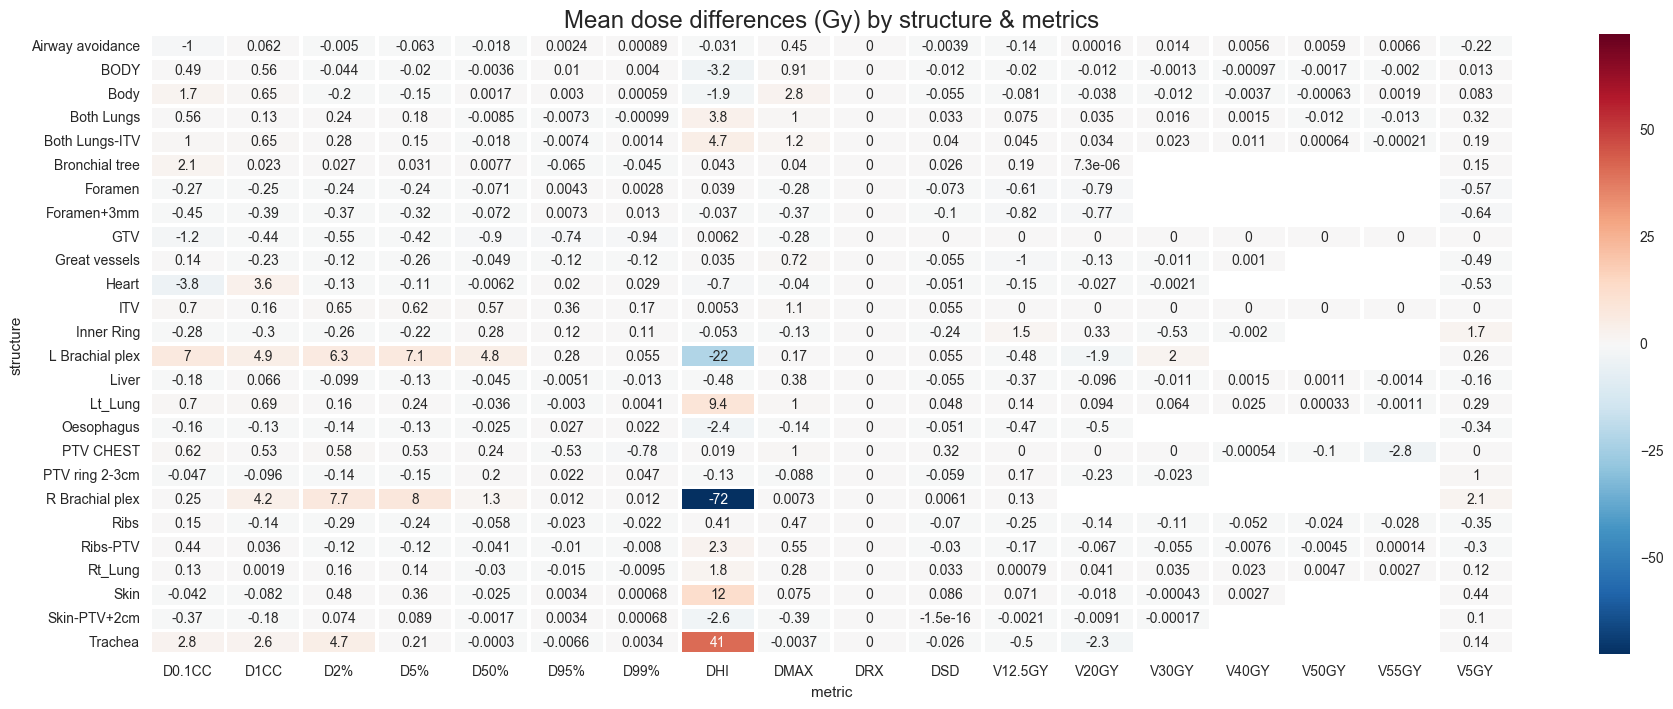

In [59]:
plt.figure(figsize=(22, 8))
ax1 = sns.heatmap(mean_diff_table, annot=True, linewidths=2.0, cbar=True)
ax1.set_title('Mean dose differences (Gy) by structure & metrics', size='xx-large');
plt.savefig('All structures and metrics mean dose difference.png', dpi=500)

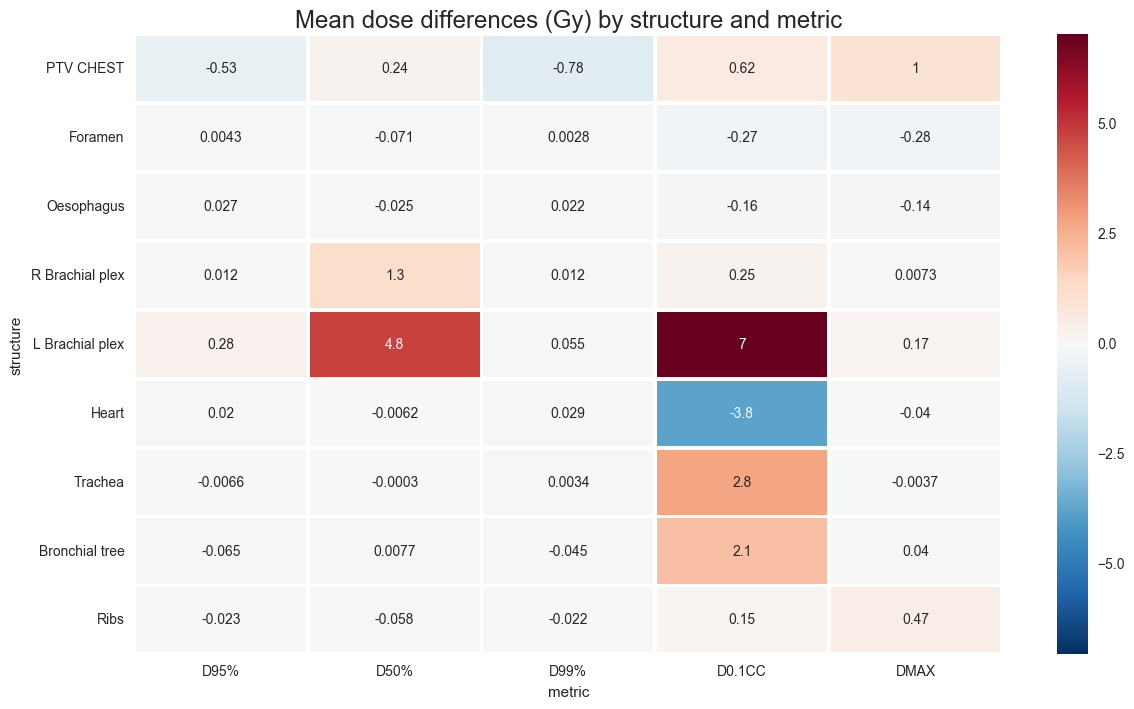

In [60]:
metrics_of_interest = [ 'D95%', 'D50%', 'D99%', 'D0.1CC', 'DMAX']
structures_of_interest = constraints['structure'].unique()

sub_diff_table = mean_diff_table[metrics_of_interest].loc[structures_of_interest]

plt.figure(figsize=(14, 8))
ax1 = sns.heatmap(sub_diff_table, annot=True, linewidths=2.0, cbar=True)
ax1.set_title('Mean dose differences (Gy) by structure and metric', size='xx-large')
plt.savefig('Select structures and metrics mean dose difference.png', dpi=500)

## Get wilcoxon p value of differences 

In [61]:
# structures_of_interest = diff_table.index.values
# structures_of_interest

In [62]:
i = len(structures_of_interest)
j = len(metrics_of_interest)
wilcox_data = np.zeros((i,j))  # init an empty array

In [63]:
j = 0
for structure in structures_of_interest:
    i = 0
    for metric in metrics_of_interest:
        A =  d[(d['structure'] == structure) & (d['metric'] == metric)]
        D =  A['diff']
        wilcox_data[j][i] = my_wilcox(D.values)
        i = i + 1
    j = j+ 1  

C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


Convert to dataframe

In [64]:
wilcox_data_df = pd.DataFrame(data=wilcox_data,    # values
...              index=structures_of_interest,    # 1st column as index
...              columns=metrics_of_interest)  # 1st row as the column names

In [65]:
wilcox_data_df

,D95%,D50%,D99%,D0.1CC,DMAX
PTV CHEST,0.191446,0.155635,0.040888,0.046826,0.005376
Foramen,0.232979,0.003772,0.211476,0.000655,0.000976
Oesophagus,0.002162,0.394246,0.012453,0.008985,0.068476
R Brachial plex,0.099540,0.139756,0.078292,0.649563,0.491119
L Brachial plex,0.064039,0.035465,0.047990,0.509797,0.440867
Heart,0.012453,0.733271,0.001206,0.532130,0.826049
Trachea,0.334277,0.909561,0.139756,0.211476,0.562351
Bronchial tree,0.019878,0.690945,0.030908,0.069144,0.665896
Ribs,0.069144,0.040888,0.023096,0.495521,0.035193


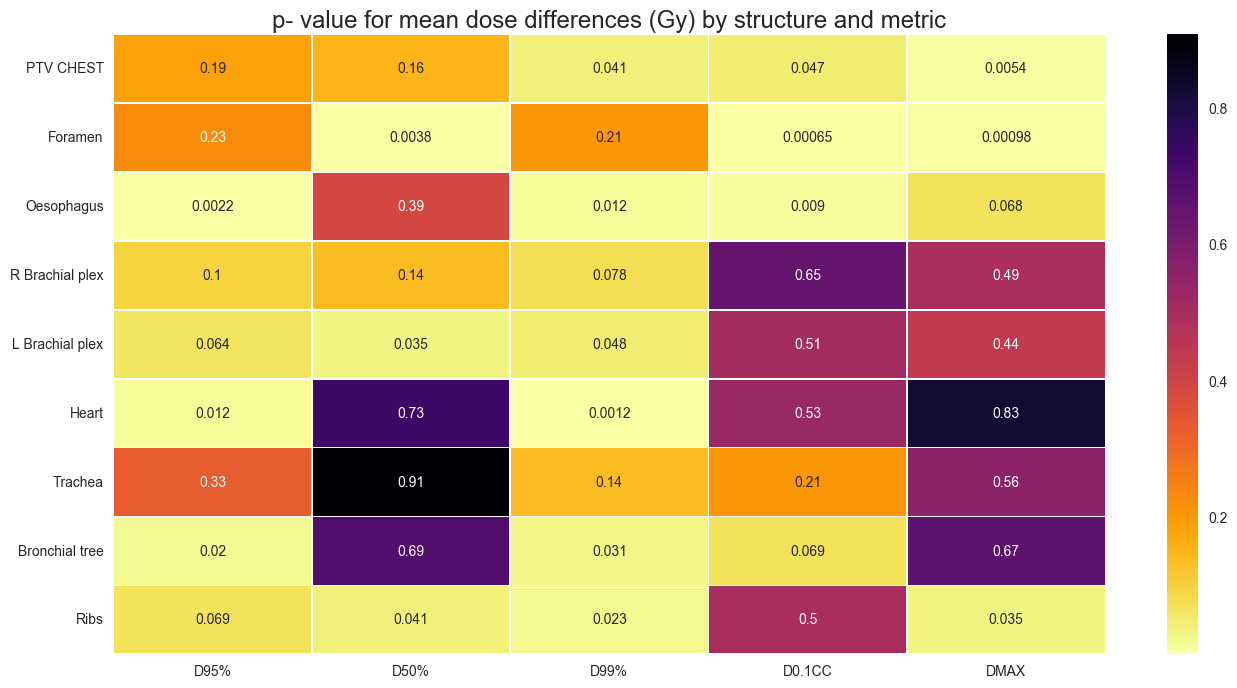

In [69]:
confidence = 1.0
plt.figure(figsize=(16, 8))
ax2 = sns.heatmap(wilcox_data_df[wilcox_data_df<confidence], annot=True, linewidths=.5,  cbar=True, cmap='inferno_r')
ax2.set_title('p- value for mean dose differences (Gy) by structure and metric', size='xx-large')
plt.savefig('p value for mean dose differences for select structure and metric.png', dpi=500)

Plot dose differences where statistically significant

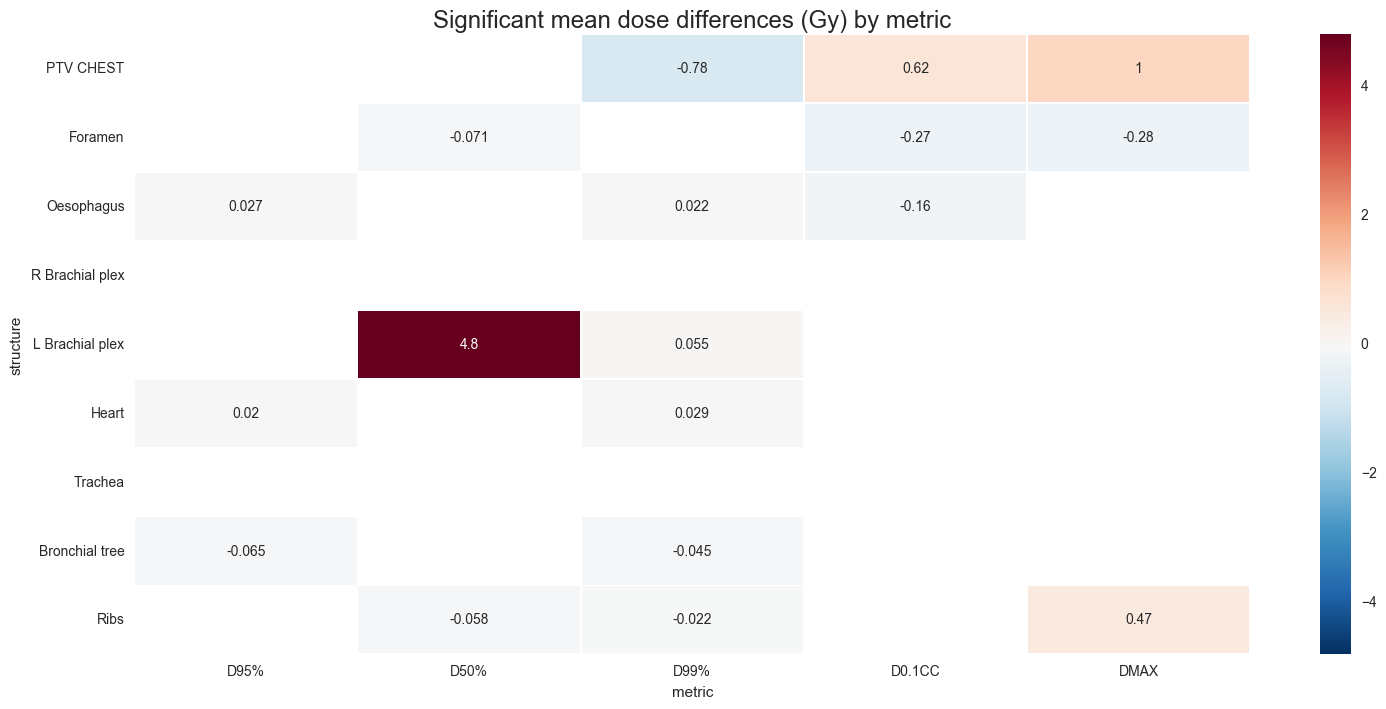

In [70]:
plt.figure(figsize=(18, 8)) 

data = sub_diff_table[wilcox_data_df<0.05]

mask = np.zeros_like(data, dtype=np.bool)   # create a mask 
mask[np.triu_indices_from(mask)] = True


ax3 = sns.heatmap(data, annot=True, linewidths=.5, center=0) #  mask=mask,
ax3.set_title('Significant mean dose differences (Gy) by metric', size='xx-large')
plt.savefig('p value for mean dose differences for significant select structure and metric.png', dpi=500)

# Max dose differences

In [72]:
res_table3 = d.groupby(['structure', 'metric'],as_index=False).max()  # just get max values 

In [96]:
max_diff_table = res_table3.pivot(index='structure', columns='metric', values='diff')  # pivot table for diff values
#diff_table.reset_index(level=0, inplace=True)    # must convert the index back into a column
max_diff_table.index
max_diff_table.loc['ITV']

metric
D0.1CC     1.767341
D1CC       1.531997
D2%        1.668766
D5%        1.687980
D50%       1.828439
D95%       1.878422
D99%       2.072069
DHI        0.064488
DMAX       2.750000
DRX        0.000000
DSD        1.045000
V12.5GY    0.000000
V20GY      0.000000
V30GY      0.000000
V40GY      0.000000
V50GY      0.000000
V55GY      0.000000
V5GY       0.000000
Name: ITV, dtype: float64

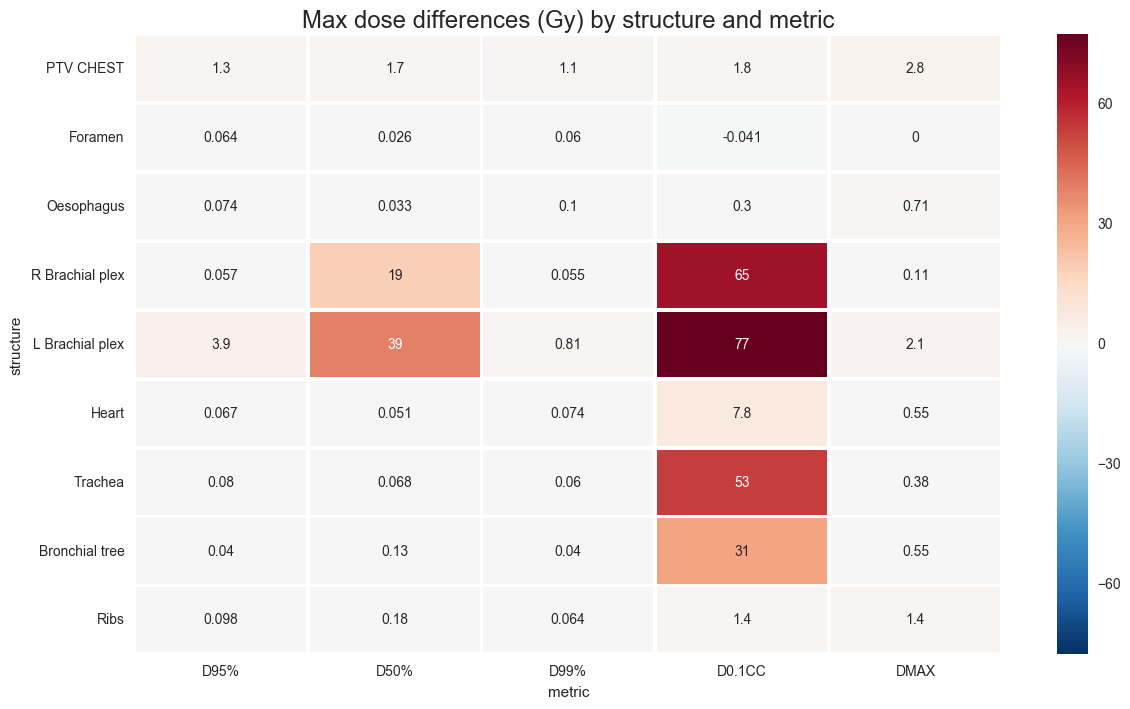

In [74]:
sub_diff_table2 = max_diff_table[metrics_of_interest].loc[structures_of_interest]

plt.figure(figsize=(14, 8))
ax1 = sns.heatmap(sub_diff_table2, annot=True, linewidths=2.0, cbar=True)
ax1.set_title('Max dose differences (Gy) by structure and metric', size='xx-large')
plt.savefig('max_table.png', dpi=500)

Combine constraints with max, mean and signifance of dose differences, and failures

In [81]:
# constraints # constraints of interes  

In [76]:
constraints_full = constraints.copy()

In [77]:
Mean_diff = mean_diff_table.lookup(constraints['structure'].values, constraints['metric'].values)  # mean diff values from lookup                              
constraints_full['Mean_diff'] = pd.DataFrame(Mean_diff)   # convert to dataframe and apply 

In [78]:
wilcox  =  wilcox_data_df.lookup(constraints['structure'].values, constraints['metric'].values)
constraints_full['wilcox'] = pd.DataFrame(wilcox)

In [79]:
Max_diff = max_diff_table.lookup(constraints['structure'].values, constraints['metric'].values)  
constraints_full['Max_diff'] = pd.DataFrame(Max_diff)

In [83]:
constraints_full = constraints_full.drop('Of_Prescription_dose?', 1) 

In [84]:
test1 = failures[(failures['structure'] == 'PTV CHEST') & ((failures['metric'] == 'D95%'))] # dose constraint violated
test1.size != 0   # True = there is a failure

True

In [85]:
failures

,Case,structure,metric,AAA,Dm,diff
489,Case5,PTV CHEST,D95%,55.648904,54.883221,-0.765683
4287,Case30,PTV CHEST,D95%,56.172306,51.618767,-4.553539
4740,Case31,PTV CHEST,D0.1CC,72.846993,74.024337,1.177344
3966,Case25,Trachea,D0.1CC,15.948424,69.349889,53.401465
3458,Case22,Liver,D50%,1.250632,1.294880,0.044248
4196,Case25,Liver,D50%,6.847959,6.713133,-0.134825
1122,Case12,L Brachial plex,D0.1CC,0.108812,74.346465,74.237653
3912,Case25,L Brachial plex,D0.1CC,0.054618,63.428739,63.374121
4650,Case31,L Brachial plex,D0.1CC,0.109680,77.576481,77.466802
222,Case1,R Brachial plex,D0.1CC,0.324991,65.801627,65.476636


In [86]:
constraints_failed = pd.merge(constraints_full, failures, how='inner', on=['structure', 'metric'])
constraints_failed  # get merged dataframe with failed constraints and details of the failure

,structure,metric,Sign,5_Fraction_55Gy,Unit,Mean_diff,wilcox,Max_diff,Case,AAA,Dm,diff
0,PTV CHEST,D95%,>,100,%,-0.526656,0.191446,1.278843,Case5,55.648904,54.883221,-0.765683
1,PTV CHEST,D95%,>,100,%,-0.526656,0.191446,1.278843,Case30,56.172306,51.618767,-4.553539
2,PTV CHEST,D0.1CC,between,118-134,%,0.619299,0.046826,1.775331,Case31,72.846993,74.024337,1.177344
3,R Brachial plex,D0.1CC,<,27,Gy,0.246638,0.649563,65.476636,Case1,0.324991,65.801627,65.476636
4,R Brachial plex,D0.1CC,<,27,Gy,0.246638,0.649563,65.476636,Case17,0.435957,48.809596,48.373640
5,L Brachial plex,D0.1CC,<,27,Gy,7.044839,0.509797,77.466802,Case12,0.108812,74.346465,74.237653
6,L Brachial plex,D0.1CC,<,27,Gy,7.044839,0.509797,77.466802,Case25,0.054618,63.428739,63.374121
7,L Brachial plex,D0.1CC,<,27,Gy,7.044839,0.509797,77.466802,Case31,0.109680,77.576481,77.466802
8,Trachea,D0.1CC,<,32,Gy,2.783140,0.211476,53.401465,Case25,15.948424,69.349889,53.401465


In [87]:
constraints_failed.to_csv('constraints_failed.csv', index=False) 

## End of presentation 1: 13/10

# Explore correlations by structure

In [88]:
diff_table = res_table2.pivot(index='structure', columns='metric', values='diff')  # pivot table for diff values
diff_table.reset_index(level=0, inplace=True)  

In [89]:
diff_table = diff_table.transpose()

In [90]:
diff_table

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
metric,,,,,,,,,,,,,,,,,,,,,
structure,Airway avoidance,BODY,Body,Both Lungs,Both Lungs-ITV,Bronchial tree,Foramen,Foramen+3mm,GTV,Great vessels,...,Oesophagus,PTV CHEST,PTV ring 2-3cm,R Brachial plex,Ribs,Ribs-PTV,Rt_Lung,Skin,Skin-PTV+2cm,Trachea
D0.1CC,-1.00434,0.491165,1.70681,0.564426,1.02532,2.121,-0.267566,-0.451062,-1.17708,0.144711,...,-0.162007,0.619299,-0.0474729,0.246638,0.153879,0.435676,0.125765,-0.0422842,-0.367425,2.78314
D1CC,0.0620816,0.555958,0.652722,0.128403,0.651453,0.0232596,-0.245973,-0.394999,-0.438024,-0.230165,...,-0.13435,0.529257,-0.0963734,4.21703,-0.136832,0.0362345,0.00186993,-0.0815714,-0.175125,2.56163
D2%,-0.0050274,-0.0437093,-0.203235,0.243395,0.283526,0.0268017,-0.244472,-0.374267,-0.550123,-0.119721,...,-0.141346,0.578552,-0.136809,7.74296,-0.289684,-0.122271,0.164522,0.475223,0.0740825,4.72959
D5%,-0.0629371,-0.0196583,-0.154865,0.183086,0.147056,0.0309386,-0.237581,-0.3241,-0.417978,-0.260709,...,-0.127596,0.534998,-0.149045,8.03198,-0.235953,-0.120511,0.139518,0.361642,0.0887758,0.2062
D50%,-0.0184049,-0.00359854,0.00167901,-0.00847416,-0.018235,0.00768176,-0.0712302,-0.0716684,-0.900259,-0.0490744,...,-0.0251354,0.235042,0.201877,1.2585,-0.0584955,-0.0409762,-0.0297332,-0.0250018,-0.0016621,-0.000303577
D95%,0.00242217,0.0103011,0.00296295,-0.00733235,-0.00738071,-0.064739,0.00431945,0.00727596,-0.741429,-0.116448,...,0.0265625,-0.526656,0.0222163,0.0124306,-0.0228813,-0.0102731,-0.0150128,0.00338544,0.0033837,-0.00663619
D99%,0.000890841,0.00396168,0.000592589,-0.000986923,0.00138929,-0.0454546,0.00277629,0.0131789,-0.941735,-0.12112,...,0.0215739,-0.780473,0.0467245,0.0118137,-0.0217932,-0.00795927,-0.00954373,0.000677088,0.000676739,0.00338609
DHI,-0.0311396,-3.19927,-1.86547,3.82,4.66052,0.0425717,0.0392441,-0.0372042,0.00620912,0.0345679,...,-2.37347,0.0191489,-0.132555,-72.316,0.408545,2.29891,1.84546,12.4507,-2.58663,40.944


In [91]:
diff_table_correlations = diff_table.corr()
diff_table_correlations

""


In [94]:
plt.figure(figsize=(18, 8))
# ax3 = sns.heatmap(diff_table_correlations , annot=True, linewidths=.5)

# Explore correlations with material data for PTV

In [45]:
PTV_CT = pd.read_csv('PTV_HU_mean_dat.csv')  # import PTV density data

In [46]:
# PTV_CT

Get the PTV differences by metric and case

In [47]:
PTV_metrics = d[d['structure']  == 'PTV CHEST']
PTV_metrics = PTV_metrics.pivot(index='Case',columns='metric', values='diff')   #pivot on case and metric
PTV_metrics.reset_index(level=0, inplace=True)    # must convert the index back into a column

del PTV_metrics['V12.5GY'] # delete as no data for them
del PTV_metrics['V5GY']
# PTV_metrics

In [48]:
PTV_all = pd.merge(PTV_metrics, PTV_CT, how='inner', on=[ 'Case'])  # Merge on case 
PTV_all

metric,Case,D0.1CC,D1CC,D2%,D5%,D50%,D95%,D99%,DHI,DMAX,DSD,mean_HU,SD_HU,Volume_PTV
0,Case1,-1.646800,-0.623945,-0.581028,-0.802292,-0.157389,-0.915495,-1.633518,2.850494,-0.381971,-4.000000,-170.699,272.993,72.9
1,Case11,1.044115,0.638813,0.633493,0.642739,0.248408,-2.628825,-3.985440,14.416879,1.655380,13.253012,-551.763,279.318,25.2
2,Case12,2.279966,0.841989,0.910143,0.601526,0.489112,0.196736,-0.240510,3.974143,3.790751,1.282051,-478.357,276.233,38.6
3,Case13,2.109205,1.769138,1.792435,1.538511,1.636643,0.199115,-0.701292,8.237426,1.984733,6.756757,-426.137,296.692,44.7
4,Case14,0.812426,0.124380,0.221460,-0.112804,1.857474,0.445066,-0.370695,-0.878065,1.803752,0.000000,-432.742,277.356,35.4
5,Case16,2.355693,2.143460,2.600956,2.655809,0.429373,-0.788578,-1.580805,12.932591,2.277580,13.829787,-601.037,225.056,8.9
6,Case17,0.776133,1.198678,1.226977,1.144944,0.914957,-0.249615,-0.725107,6.958105,1.416853,2.777778,-275.691,359.180,77.3
7,Case18,2.824736,2.444145,2.870780,2.600269,1.813520,1.118255,1.763484,5.879023,3.427266,8.000000,-559.114,243.114,14.1
8,Case22,-0.101734,0.334918,0.264370,0.389630,0.299438,-0.164480,-0.190877,1.062469,-0.221239,2.352941,-363.164,293.196,35.6
9,Case23,2.312454,2.861348,2.438215,2.914029,1.090400,-0.589348,-1.212738,13.153501,1.972243,16.250000,-650.879,179.334,13.3


In [49]:
# sns.pairplot(PTV_all)

In [50]:
PTV_correlations = PTV_all.corr()
PTV_correlations

metric,D0.1CC,D1CC,D2%,D5%,D50%,D95%,D99%,DHI,DMAX,DSD,mean_HU,SD_HU,Volume_PTV
metric,,,,,,,,,,,,,
D0.1CC,1.000000,0.617233,0.906268,0.796625,0.400423,0.340136,0.359652,0.041674,0.914514,0.167788,-0.307133,-0.165632,-0.265892
D1CC,0.617233,1.000000,0.713018,0.894005,0.724770,0.686345,0.682077,-0.440057,0.454783,-0.164922,0.027899,0.202278,-0.050963
D2%,0.906268,0.713018,1.000000,0.928403,0.399044,0.350939,0.383756,0.061968,0.742861,0.194483,-0.225131,-0.166141,-0.225930
D5%,0.796625,0.894005,0.928403,1.000000,0.501597,0.445250,0.462563,-0.085805,0.586004,0.141344,-0.204784,-0.064768,-0.244744
D50%,0.400423,0.724770,0.399044,0.501597,1.000000,0.952730,0.908601,-0.831142,0.346984,-0.711395,0.550795,0.602303,0.458585
D95%,0.340136,0.686345,0.350939,0.445250,0.952730,1.000000,0.985553,-0.908367,0.318612,-0.800725,0.623298,0.579437,0.504028
D99%,0.359652,0.682077,0.383756,0.462563,0.908601,0.985553,1.000000,-0.885961,0.338290,-0.763182,0.573815,0.502432,0.448762
DHI,0.041674,-0.440057,0.061968,-0.085805,-0.831142,-0.908367,-0.885961,1.000000,0.001690,0.914548,-0.724182,-0.663931,-0.580604
DMAX,0.914514,0.454783,0.742861,0.586004,0.346984,0.318612,0.338290,0.001690,1.000000,0.052740,-0.225475,-0.098497,-0.174584


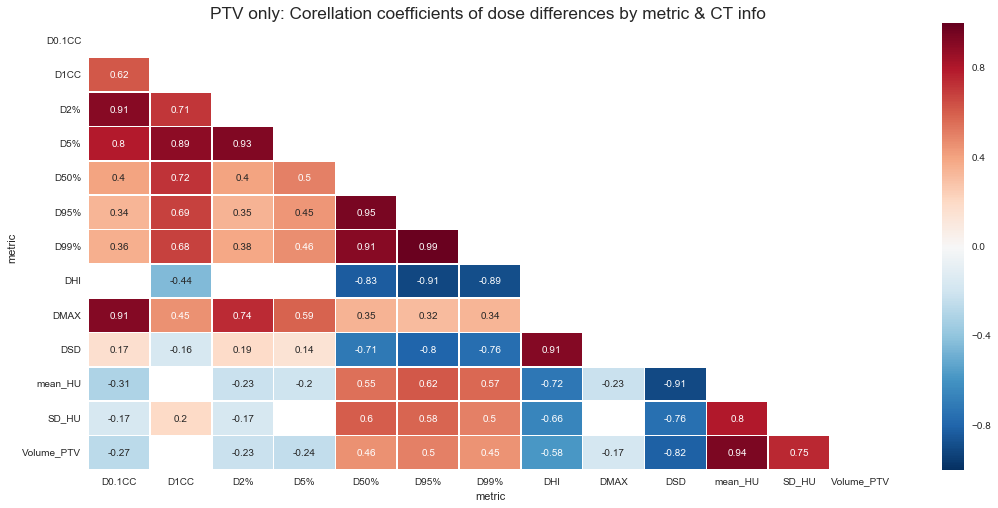

In [51]:
threshold = 0.1  # only show correlation coefficients greater than a threshold value
plt.figure(figsize=(18, 8)) 
mask = np.zeros_like(PTV_correlations, dtype=np.bool)   # create a mask 
mask[np.triu_indices_from(mask)] = True


ax4 = sns.heatmap(PTV_correlations[PTV_correlations.abs() > threshold], annot=True, mask=mask, linewidths=.5, center=0)
ax4.set_title('PTV only: Corellation coefficients of dose differences by metric & CT info ', size='xx-large')

# Investigate corellations 

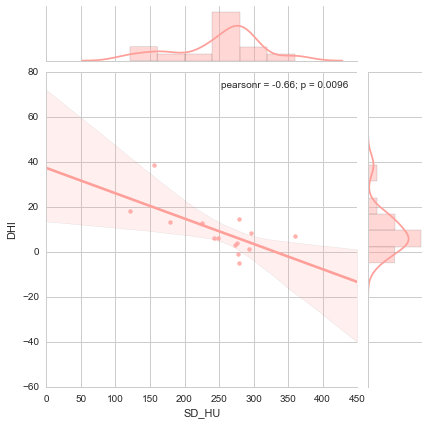

In [143]:
sns.jointplot( "SD_HU","DHI", data=PTV_all, kind="reg", color="r", size=6)
plt.savefig('corrplot1.png', dpi=300)

# Testing

7.55692945586e-10
7.55692945586e-10


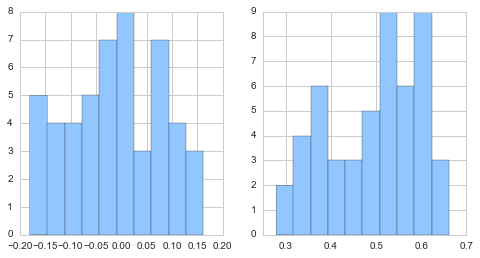

In [32]:
#Test of wilcoxon. See how size of distribution and difference in mean affect result p 

dist_diff = 0.5
samples = 50

mu, sigma = 0, 0.1 
s = np.random.normal(mu, sigma, samples)

mu2, sigma = 0+dist_diff, 0.1 
s2 = np.random.normal(mu2, sigma, samples)

fig = plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(s)

plt.subplot(1, 2, 2)
plt.hist(s2)

z_stat, p_val = wilcoxon(s, s2)   # if only 1 value passed
print(p_val)

z_stat, p_val = wilcoxon(s-s2)   # if only 1 value passed
print(p_val)